## Installation of Libraries

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
#   !pip install -q pyomo
#   !apt-get install -y -qq glpk-utils
#   !apt-get install -y -qq coinor-cbc
#   !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
#   !unzip -o -q ipopt-linux64
  !pip install ttictoc
  !pip install casadi
  !pip install osqp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import Libraries

In [2]:
from casadi import *
import numpy as np
import osqp
import scipy as sp
from scipy import sparse
from ttictoc import tic,toc

## Define Variables, System Dynamics, and Optimization Solver

In [22]:
dt = 1.0 / 30.0
g = 9.81
N = 10
M = 400
disturbance_rejection = True

alpha = 0.0 # pitch and roll coupling (0.0 -> 1.0)
gravity_percentage = 1.0 # acceleration due to gravity (0.0 -> 1.0)
input_percentage = 1.0 # ratio of input to provide for simuation

pitch_offset = 1.5 # degrees
roll_offset = 1.5 # degrees

In [12]:
def system_dynamics(state, input, dt):

    pitch = pitch_offset*np.pi/180 + state[4]
    roll = roll_offset*np.pi/180 + state[5]

    g_mod = g * 1.0

    state_new = np.zeros(6)

    input[1] = input[1] * 1.0
    input[0] = input[0] * 1.0

    state_new[0] = state[0] + dt*state[2] # + (np.random.rand()-0.5)*0.001
    state_new[1] = state[1] + dt*state[3] # + (np.random.rand()-0.5)*0.001
    state_new[2] = state[2] + dt*g_mod*np.sin(pitch) + (np.random.rand()-0.5)*0.007
    state_new[3] = state[3] - dt*g_mod*np.sin(roll)*np.cos(pitch) + (np.random.rand()-0.5)*0.007
    state_new[4] = state[4] + dt*((1-alpha)*input[0] + (alpha)*input[1]) #(np.random.rand()-0.5)*0.01
    state_new[5] = state[5] + dt*((1-alpha)*input[1] + (alpha)*input[0]) #(np.random.rand()-0.5)*0.01

    return state_new, input

In [13]:
def solveMPC(x0, u0, xref, uref, d):

    N = 10
    dt = 1/30
    g = 9.81

    angle_rate_limit = 0.2  
    angle_acc_limit = 0.01
    angle_limit = np.pi/6

    # weights = [60, 60, 5, 5, 10, 10]
    weights = [20, 20, 1, 1, 10, 10]

    opti = Opti() # Optimization problem

    X = opti.variable(6,N+1)
    xpos  = X[0,:]
    ypos  = X[1,:]
    xvel  = X[2,:]
    yvel  = X[3,:]
    pitch = X[4,:]
    roll  = X[5,:]

    U = opti.variable(2,N)
    pvel  = U[0,:]
    rvel  = U[1,:]

    # Objective

    Bd = np.array([1, 1, 1, 1, 1, 1, 1])

    f = lambda x,u: vertcat(x[0] +   dt*x[2] + Bd[0]*d[0],
                            x[1] +   dt*x[3] + Bd[1]*d[1],
                            x[2] + dt*g*x[4] + Bd[2]*d[2],
                            x[3] - dt*g*x[5] + Bd[3]*d[3],
                            x[4] +   dt*u[0] + Bd[4]*d[4],
                            x[5] +   dt*u[1] + Bd[5]*d[5])
    
    xref[4, :] = xref[2, :] - d[2] / (g*dt)
    xref[5, :] = xref[3, :] + d[3] / (g*dt)

    Q = DM.eye(6)
    for i in range(6):
        Q[i, i] = weights[i]
    P = Q
    R = DM.eye(2)*0.2

    cost = (X[:, N] - xref[:, N]).T@P@(X[:, N] - xref[:, N])

    for k in range(N):
        x_next = f(X[:,k], U[:,k])
        opti.subject_to(X[:,k+1]==x_next)

        cost += (X[:, k] - xref[:, k]).T@Q@(X[:, k] - xref[:, k]) + U[:, k].T@R@U[:, k]

        if k < N-1:
        
            opti.subject_to(opti.bounded(-angle_acc_limit,(pvel[k+1] - pvel[k]),angle_acc_limit))
            opti.subject_to(opti.bounded(-angle_acc_limit,(rvel[k+1] - rvel[k]),angle_acc_limit))

    opti.subject_to(opti.bounded(-angle_limit,pitch, angle_limit)) # control is limited
    opti.subject_to(opti.bounded(-angle_limit, roll, angle_limit)) # control is limited

    opti.subject_to(opti.bounded(-angle_rate_limit,pvel,angle_rate_limit)) # control is limited
    opti.subject_to(opti.bounded(-angle_rate_limit,rvel,angle_rate_limit)) # control is limited

    # Initial Constraints

    opti.subject_to(xpos[0] ==x0[0])
    opti.subject_to(ypos[0] ==x0[1])
    opti.subject_to(xvel[0] ==x0[2])
    opti.subject_to(yvel[0] ==x0[3])
    opti.subject_to(pitch[0]==x0[4])
    opti.subject_to(roll[0] ==x0[5])

    # Final Constraints

    # opti.subject_to(xpos[-1]==0)
    # opti.subject_to(ypos[-1]==0)
    # opti.subject_to(xvel[-1]==0)
    # opti.subject_to(yvel[-1]==0)
    # opti.subject_to(pitch[-1]==0)
    # opti.subject_to(roll[-1]==0)

    # Warm Start Constraints

    opti.subject_to(opti.bounded(-angle_acc_limit,(pvel[0] - u0[0]),angle_acc_limit))
    opti.subject_to(opti.bounded(-angle_acc_limit,(rvel[0] - u0[1]),angle_acc_limit))

    # opti.subject_to(pvel[0]==u0[0])
    # opti.subject_to(rvel[0]==u0[1])

    opti.minimize(cost)

    # Solve

    p_opts = dict(print_time=False, verbose=False)
    s_opts = dict(print_level=0)
    opti.solver("ipopt", p_opts, s_opts)

    sol = opti.solve()   # actual solve

    # return sol.value(xpos), sol.value(ypos), sol.value(xvel), sol.value(yvel), sol.value(pvel)[0], sol.value(rvel)[0]
    return sol.value(X), sol.value(U)


## Run MPC

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import time
import numpy as np
from scipy import signal

def reference(t):
    if t < 200:
        return np.zeros(6)
    else:
        return np.array([0.1, 0.1, 0.0, 0.0, 0.0, 0.0])

t = 0

# keep track of current state
state = np.zeros((M+1, 6))
state[0, :] = np.array([-0.0, -0.0, -0.0, -0.0, -0.0, -0.0])

# keep track of open-loop predictions
open_loop = np.zeros((M, 6, N+1))

# keep track of input sequence
prev_input = np.zeros((M+1, 2))

# keep track of disturbance understanding
dist = np.zeros((M+1, 6))
K_i = np.diag([-0.01, -0.01, -0.5, -0.5, -0.1, -0.1])


while t < M:

    X_ref = np.zeros((6, N+1))
    U_ref = np.zeros((2, N+1))
    
    for i in range(N+1):
        X_ref[:, i] = reference(t+i)


    # Solve MPC


    if disturbance_rejection:
        # With Disturbance Understanding
        X_pred, U_pred = solveMPC(state[t, :], prev_input[t, :], X_ref, U_ref, dist[t, :])
    else:
        # Without Disturbance Understanding
        X_pred, U_pred = solveMPC(state[t, :], prev_input[t, :], X_ref, U_ref, np.zeros(6))

    # Save open loop trajectories
    open_loop[t, :, :] = X_pred
    
    # Simulate the first applied input
    input = U_pred[:, 0]
    X_act, U_act = system_dynamics(state[t, :], input, dt)

    state[t+1, :] = X_act
    prev_input[t+1, :] = U_act

    # Compare Actual Results and Open-Loop Predictions
    xvel_act = X_act[2]
    yvel_act = X_act[3]

    xvel_pred = X_pred[2, 1]
    yvel_pred = X_pred[3, 1]

    # dist[t+1, 2] = dist[t, 2] - K_d*(xvel_pred - xvel_act)
    # dist[t+1, 3] = dist[t, 3] - K_d*(yvel_pred - yvel_act)

    if disturbance_rejection:
        dist[t+1, :] = dist[t, :] + K_i@(X_pred[:, 1] - X_act[:])

    t += 1

print('Done')

Done


## Plotting

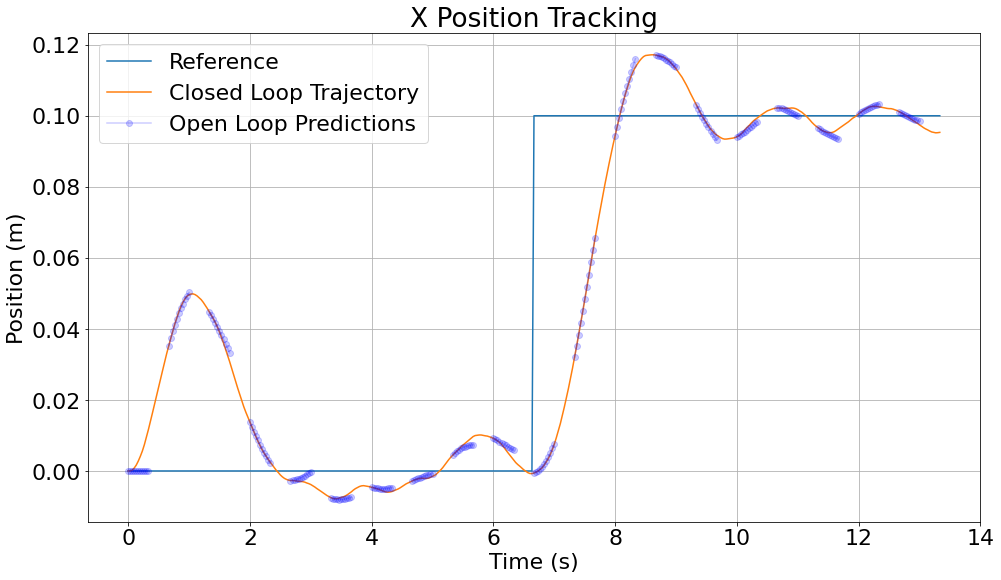

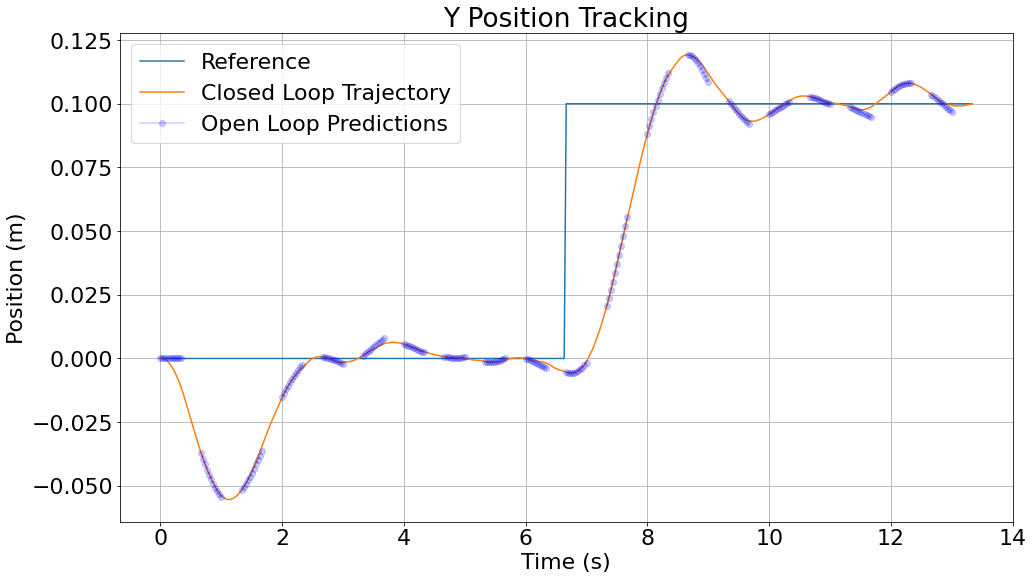

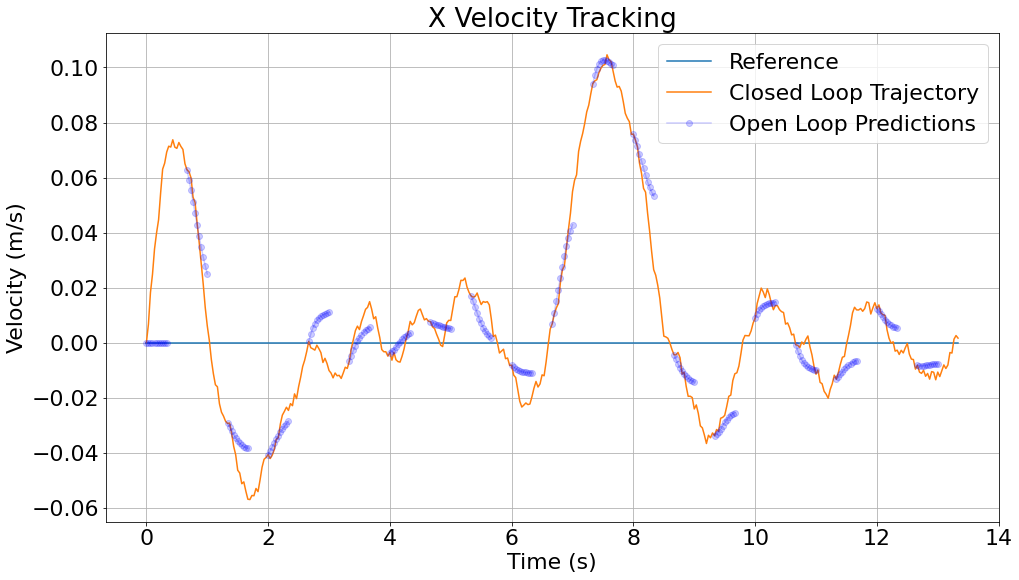

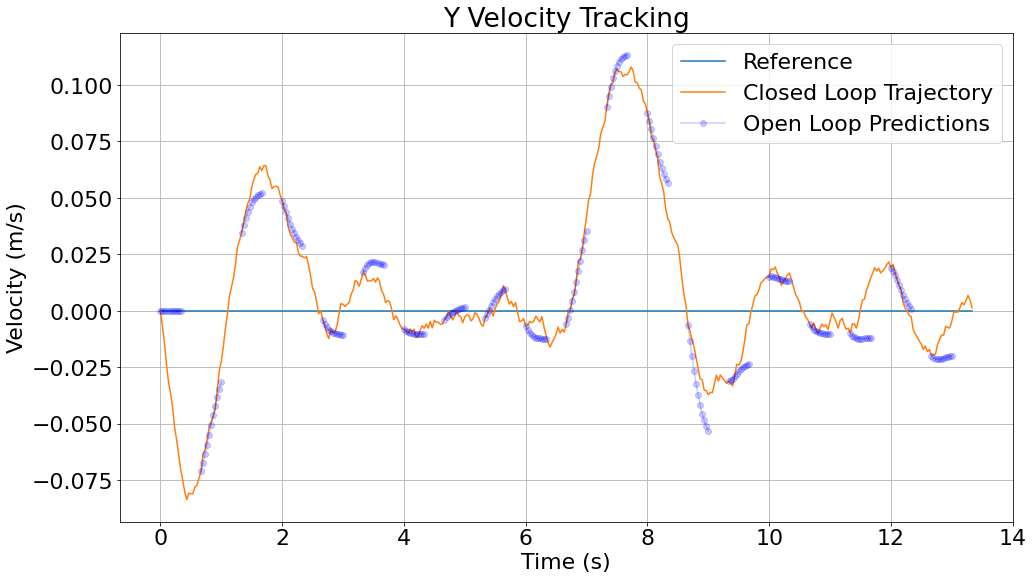

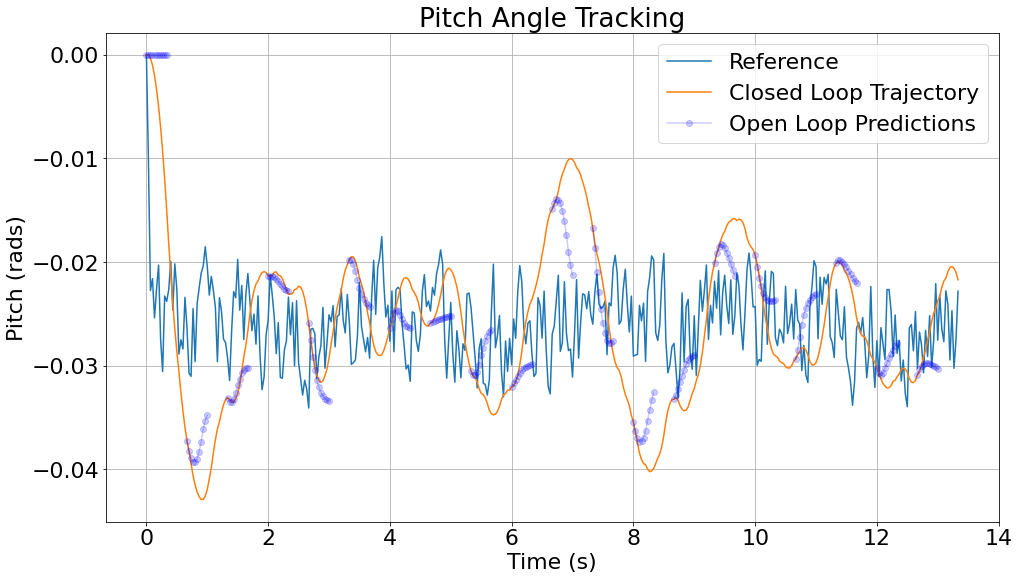

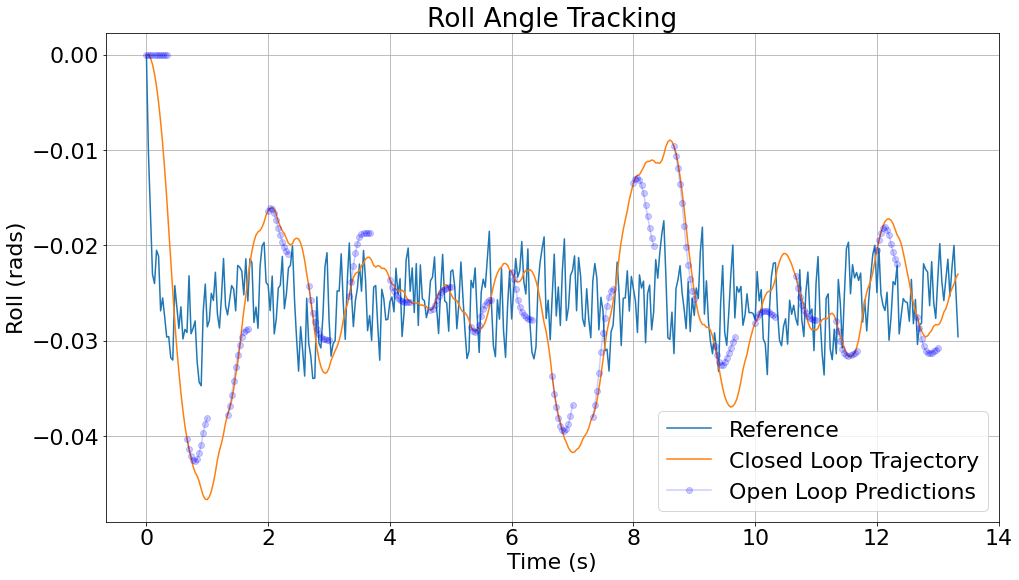

In [15]:
import matplotlib

matplotlib.rcParams.update({'font.size': 22})

t_span = np.linspace(0, M*dt, M+1)

g = 9.81

title = ['X Position Tracking', 'Y Position Tracking', 'X Velocity Tracking', 'Y Velocity Tracking', 'Pitch Angle Tracking', 'Roll Angle Tracking']
ylabel = ['Position (m)', 'Position (m)', 'Velocity (m/s)', 'Velocity (m/s)', 'Pitch (rads)', 'Roll (rads)']
xlabel = ['Time (s)']*6

legend = ['Reference', 'Closed Loop Trajectory', 'Open Loop Predictions']

for s in range(6):
    fig = plt.figure(figsize=(16,9))
    ax = plt.subplot(1,1,1) 

    ax.grid()

    if s == 4:
        ax.plot(t_span, [(reference(i)[s] - dist[i, (s - 2)]*30/9.81) for i in range(M+1)])
    elif s == 5:
        ax.plot(t_span, [(reference(i)[s] + dist[i, (s - 2)]*30/9.81) for i in range(M+1)])
    else:
        ax.plot(t_span, [reference(i)[s] for i in range(M+1)])
    ax.plot(t_span, state[:, s])

    # plot open loop predictions
    for i in range(M):
        if i % 20 == 0:
            t_span_open = np.linspace(i*dt, (i+N)*dt, N+1)
            ax.plot(t_span_open, open_loop[i, s, :], 'bo-', alpha=0.2)

    ax.legend(legend)
    ax.set_title(title[s])
    ax.set_ylabel(ylabel[s])
    ax.set_xlabel(xlabel[s])

    plt.savefig('{} no rejection.png'.format(s))

    plt.show()

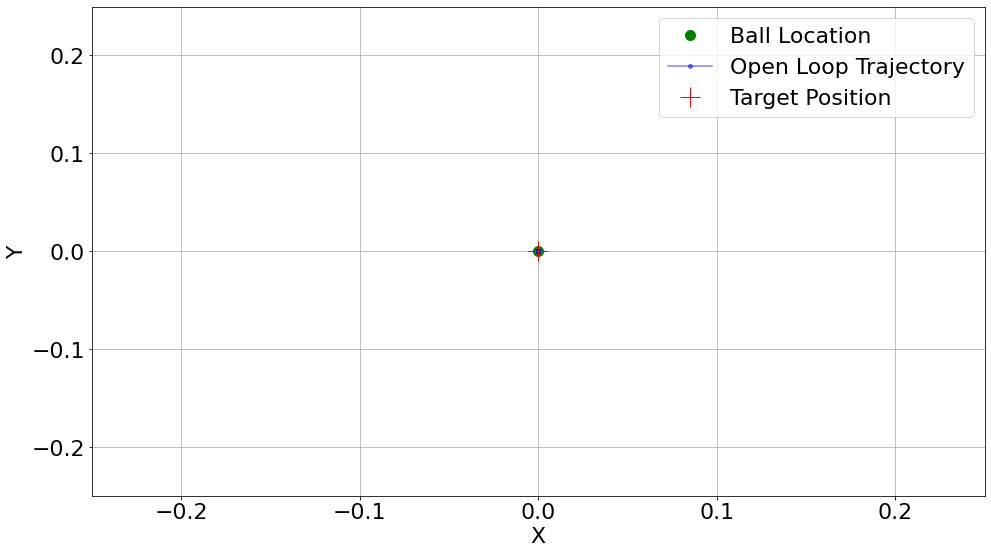

In [19]:
fig = plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1) 

ax.set_xlim((-0.25, 0.25))            
ax.set_ylim((-0.25, 0.25))
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.grid()

main, = ax.plot([], [], 'g.', ms=20)
predicted, = ax.plot([], [], 'bo-', ms=4, alpha=0.5)
ref, = ax.plot([], [], 'r+', ms=20)

ax.legend(['Ball Location', 'Open Loop Trajectory', 'Target Position'])

def drawframe(n):

    main.set_data(state[n, 0], state[n, 1])
    predicted.set_data(open_loop[n, 0, :], open_loop[n, 1, :])

    r = reference(n)
    ref.set_data(r[0], r[1])

    return main

anim = animation.FuncAnimation(fig, drawframe, frames=M, interval=30, blit=False)

from IPython.display import HTML
HTML(anim.to_html5_video())

## Saved OSQP Solver for Reference

In [9]:

def solveMPC_osqp(x0, u0, xr):
  
    dt = 1/30
    g = 9.81
    angle_rate_limit = 0.1  
    angle_acc_limit = 0.01
    angle_limit = np.pi/6

    # Discrete time model of ball on plate
    Ad = sparse.csc_matrix([
    [1, 0, dt, 0, 0, 0],
    [0, 1, 0, dt, 0, 0],
    [0, 0, 1, 0, dt*g, 0],
    [0, 0, 0, 1, 0, -dt*g],
    [0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 1],
    ])
    # print(Ad)
    Bd = sparse.csc_matrix([
    [0, 0],
    [0, 0],
    [0, 0],
    [0, 0],
    [dt, 0],
    [0, dt],
    ])
    # print(Bd)
    [nx, nu] = Bd.shape
    # print([nx, nu])

    # Constraints
    umin = np.array([-angle_rate_limit, -angle_rate_limit])
    umax = np.array([angle_rate_limit, angle_rate_limit])
    xmin = np.array([-np.inf, -np.inf, -np.inf, -np.inf, -angle_limit, -angle_limit])
    xmax = np.array([np.inf, np.inf, np.inf, np.inf, angle_limit, angle_limit])

    # Objective function
    Q = sparse.diags([20., 20., 1., 1., 5., 5.]) # TUNE
    QN = Q
    R = 0.2*sparse.eye(2) # TUNE

    # Initial and reference states
    # xr = np.array([0.,0.,0.,0.,0.,0.]) # TUNE
    xr = xr

    # Prediction horizon
    N = 30

    # Cast MPC problem to a QP: x = (x(0),x(1),...,x(N),u(0),...,u(N-1))
    # - quadratic objective
    P = sparse.block_diag([sparse.kron(sparse.eye(N), Q), QN,
                        sparse.kron(sparse.eye(N), R)], format='csc')
    # print(P)
    # print(P.shape)
    # print(Q.shape)
    # - linear objective
    q = np.hstack([np.kron(np.ones(N), -Q.dot(xr)), -QN.dot(xr),
                np.zeros(N*nu)])
    # print(q)
    # print(q.shape)
    # print(Q.dot(xr).shape)
    # - linear dynamics
    Ax = sparse.kron(sparse.eye(N+1),-sparse.eye(nx)) + sparse.kron(sparse.eye(N+1, k=-1), Ad)
    Bu = sparse.kron(sparse.vstack([sparse.csc_matrix((1, N)), sparse.eye(N)]), Bd)
    Aeq = sparse.hstack([Ax, Bu])
    leq = np.hstack([-x0, np.zeros(N*nx)])
    ueq = leq
    # - input and state constraints
    Aineq = sparse.eye((N+1)*nx + N*nu)
    lineq = np.hstack([np.kron(np.ones(N+1), xmin), np.kron(np.ones(N), umin)])
    uineq = np.hstack([np.kron(np.ones(N+1), xmax), np.kron(np.ones(N), umax)])

    diagonals = [np.hstack([np.zeros((N+1)*nx), np.ones(N*nu)]), np.hstack([np.zeros((N+1)*nx), np.ones((N-1)*nu)*-1])]
    Aacc = sparse.diags(diagonals, [0, -nu])
    uacc = np.hstack([np.zeros((N+1)*nx), angle_acc_limit + u0[0], angle_acc_limit + u0[1], np.kron(np.ones((N-1)*nu), angle_acc_limit)])
    lacc = np.hstack([np.zeros((N+1)*nx), -angle_acc_limit + u0[0], -angle_acc_limit + u0[1], np.kron(np.ones((N-1)*nu), -angle_acc_limit)])

    # print(Aeq.shape)
    # print(Aineq.shape)
    # print(Aacc.shape)

    # - OSQP constraints
    A = sparse.vstack([Aeq, Aineq, Aacc], format='csc')
    l = np.hstack([leq, lineq, lacc])
    u = np.hstack([ueq, uineq, uacc])

    # print(u.shape)

    # Create an OSQP object
    prob = osqp.OSQP()

    # Setup workspace
    prob.setup(P, q, A, l, u, warm_start=True, verbose=False)

    res = prob.solve()

    ctrl = res.x[-N*nu:-(N-1)*nu]
    # x0 = Ad.dot(x0) + Bd.dot(ctrl)
    x = res.x[0:(N+1)*nx:nx]
    y = res.x[1:(N+1)*nx:nx]

    # print(res.x[:])

    # Simulate in closed loop
    # nsim = nsim
    # for i in range(nsim):
    #     # Solve
    #     res = prob.solve()

    #     # Check solver status
    #     if res.info.status != 'solved':
    #         raise ValueError('OSQP did not solve the problem!')

    #     # Apply first control input to the plant
    #     ctrl = res.x[-N*nu:-(N-1)*nu]
    #     x0 = Ad.dot(x0) + Bd.dot(ctrl)

    #     # Update initial state
    #     l[:nx] = -x0
    #     u[:nx] = -x0
    #     prob.update(l=l, u=u)

    return np.asarray(x), np.asarray(y), np.asarray(ctrl)

# x, y, input = solveMPC_osqp(np.array([0.1, 0.1, 0, 0, 0, 0]), np.zeros(2))

# print(input)

## Google Drive Saving

In [21]:
from google.colab import drive
drive.mount('/content/drive')

writer=animation.FFMpegWriter(fps=30)
anim.save('/content/drive/MyDrive/dist_rej.mp4',
          writer=writer, dpi=100)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
